In [1]:
%cd ..

import os
import glob
import json
import random
from tqdm.notebook import tqdm

import cv2 
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from modules.image_processing import augment_image

%matplotlib inline

/Users/kx/Docs/github/git_chinese_calligraphy-recognition/chinese-calligraphy-recognition


## Intraclass Variant Clustering

Cluster data into variants based on spatial layout within class to address the intraclass imbalance issue.

### Feature Selection

Possible descriptors
* HoG
* pHash
* GIST

We want to select the feature that can minimise distance between similar images and maximize distance between variants in order to obtained well-separated clusters.

To compare the descriptors, L2 distance between a few hand-picked clusters are estimated using the mean feature extracted using different descriptors.

#### Manual Variant Grouping

In [2]:
# read data
data_dir = 'data/clustering'
images = {}

for file in glob.glob(data_dir + '/*/*/*.png'):
    _, _, char, group, _ = file.split('/')
    img = cv2.imread(file)
    if char not in images:
        images[char] = {}
    if group not in images[char]:
        images[char][group] = []
    images[char][group].append(img[:, :, 0])

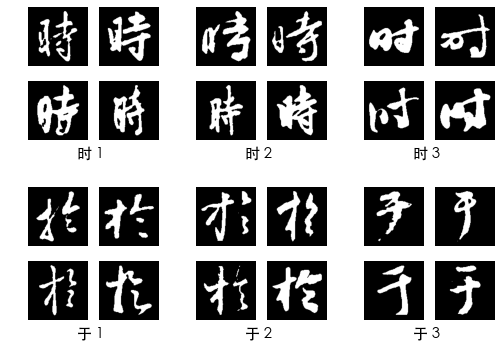

In [3]:
chars = list(images.keys())
chinese_font = mpl.font_manager.FontProperties(fname='fonts/heiti.ttf')
fig = plt.figure(figsize=(7, 2.5 * len(images)))
subfigs = fig.subfigures(len(images), 3)

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(2, 2)
    for innerind, ax in enumerate(axs.flat):
        ax.imshow(images[chars[outerind // 3]][str(outerind % 3 + 1)][innerind], 'gray')
        ax.axis("off")

    subfig.suptitle(
        '{} {}'.format(chars[outerind // 3], str(outerind % 3 + 1)), 
        y=0.1, 
        fontproperties=chinese_font,
        fontsize=15
    )
        
plt.show()

In [4]:
def hog_extractor(image):
    
    nbins = 9
    cell_size = (8, 8)
    cell_num = (2, 2)
    
    win_size = (
        image.shape[1] // cell_size[1] * cell_size[1], 
        image.shape[0] // cell_size[0] * cell_size[0]
    )
    block_size = (cell_num[0] * cell_size[0], cell_num[1] * cell_size[1])
    block_stride = cell_size
    
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    return hog.compute(image)[:, 0]


def phash_extractor(image):
    return cv2.img_hash.pHash(image)[0, :]


def gist_extractor(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, 3).repeat(3, axis=2)

    nblocks = 4
    ops = (8, 8, 4)
    return gist.extract(
        image.astype('uint8'), 
        nblocks=nblocks, 
        orientations_per_scale=ops)[:nblocks * sum(ops)]

In [5]:
print(
    """
        Feature dimension
        ==================
        HoG   - {}
        pHash - {}
        GIST  - {}
    """.format(
        hog_extractor(images[chars[0]]['1'][0]).shape,
        phash_extractor(images[chars[0]]['1'][0]).shape,
        gist_extractor(images[chars[0]]['1'][0]).shape
    )
)


        Feature dimension
        HoG   - (8100,)
        pHash - (8,)
        GIST  - (320,)
    


#### Distance Estimation

In [6]:
def estimate_features(images, extractor):

    features = {}
    for char in images:
        features[char] = {}
        for var in images[char]:
            var_fs = [extractor(image) for image in images[char][var]]        
            features[char][var] = sum(var_fs) / len(var_fs)
            
    return features


def l2_dist(f1, f2):
    return np.sqrt((f1 - f2) ** 2).sum()


features = {}
features['hog'] = estimate_features(images, hog_extractor)
features['phash'] = estimate_features(images, phash_extractor)
features['gist'] = estimate_features(images, gists_extractor)

In [8]:
res = []
for feature in features:
    for char in features[feature]:
        d = {
            'feature': feature,
            'char': char,
            '1 vs 2': l2_dist(features[feature][char]['1'], features[feature][char]['2']), # similar
            '1 vs 3': l2_dist(features[feature][char]['1'], features[feature][char]['3']), # variant
        }
        d['score'] = d['1 vs 3'] / d['1 vs 2']
        res.append(d)
        
# tidy data into df
df = pd.json_normalize(res) \
    .melt(id_vars=['feature', 'char'], var_name='') \
    .pivot_table(index=['char', ''], columns='feature')['value']
df.columns.name = ''
df.round(2)

gist     hog   phash
char                             
于    1 vs 2  0.30  303.03  137.75
     1 vs 3  0.51  392.81  167.25
     score   1.71    1.30    1.21
时    1 vs 2  0.36  330.73  180.75
     1 vs 3  0.62  444.32  200.00
     score   1.72    1.34    1.11

GIST is selected as the feature descriptor as it gives the highest score for all characters.

### Clustering

The number of clusters are determined based on the silhouette score, a class will remain to have one cluster if the score doesn't exceed a certain threshold.

In [9]:
# read data
data_dir = 'data/shufadict/clean'
ext_data_dir = 'data/hanwen360/clean' # external data
images = {}

for file in glob.glob(data_dir + '/*/*.png') + (glob.glob(ext_data_dir + '/*/*.png')):
    char = file.split('/')[-2]
    img = cv2.imread(file)
    if char not in images:
        images[char] = []
    images[char].append(img[:, :, 0])

In [10]:
# extract gist feature for all data
img_gists = {char: [gist_extractor(img) for img in tqdm(images[char], desc=char)] for char in images}

后:   0%|          | 0/96 [00:00<?, ?it/s]

家:   0%|          | 0/96 [00:00<?, ?it/s]

无:   0%|          | 0/96 [00:00<?, ?it/s]

和:   0%|          | 0/96 [00:00<?, ?it/s]

如:   0%|          | 0/96 [00:00<?, ?it/s]

多:   0%|          | 0/96 [00:00<?, ?it/s]

有:   0%|          | 0/96 [00:00<?, ?it/s]

最:   0%|          | 0/96 [00:00<?, ?it/s]

面:   0%|          | 0/96 [00:00<?, ?it/s]

要:   0%|          | 0/96 [00:00<?, ?it/s]

国:   0%|          | 0/96 [00:00<?, ?it/s]

女:   0%|          | 0/96 [00:00<?, ?it/s]

好:   0%|          | 0/96 [00:00<?, ?it/s]

看:   0%|          | 0/96 [00:00<?, ?it/s]

着:   0%|          | 0/141 [00:00<?, ?it/s]

在:   0%|          | 0/96 [00:00<?, ?it/s]

己:   0%|          | 0/96 [00:00<?, ?it/s]

小:   0%|          | 0/96 [00:00<?, ?it/s]

现:   0%|          | 0/172 [00:00<?, ?it/s]

就:   0%|          | 0/96 [00:00<?, ?it/s]

把:   0%|          | 0/154 [00:00<?, ?it/s]

发:   0%|          | 0/96 [00:00<?, ?it/s]

手:   0%|          | 0/96 [00:00<?, ?it/s]

起:   0%|          | 0/96 [00:00<?, ?it/s]

可:   0%|          | 0/96 [00:00<?, ?it/s]

们:   0%|          | 0/79 [00:00<?, ?it/s]

过:   0%|          | 0/96 [00:00<?, ?it/s]

情:   0%|          | 0/96 [00:00<?, ?it/s]

而:   0%|          | 0/96 [00:00<?, ?it/s]

以:   0%|          | 0/96 [00:00<?, ?it/s]

心:   0%|          | 0/104 [00:00<?, ?it/s]

从:   0%|          | 0/96 [00:00<?, ?it/s]

能:   0%|          | 0/96 [00:00<?, ?it/s]

中:   0%|          | 0/96 [00:00<?, ?it/s]

美:   0%|          | 0/96 [00:00<?, ?it/s]

会:   0%|          | 0/111 [00:00<?, ?it/s]

个:   0%|          | 0/169 [00:00<?, ?it/s]

也:   0%|          | 0/96 [00:00<?, ?it/s]

事:   0%|          | 0/96 [00:00<?, ?it/s]

想:   0%|          | 0/112 [00:00<?, ?it/s]

之:   0%|          | 0/96 [00:00<?, ?it/s]

一:   0%|          | 0/116 [00:00<?, ?it/s]

当:   0%|          | 0/96 [00:00<?, ?it/s]

总:   0%|          | 0/95 [00:00<?, ?it/s]

然:   0%|          | 0/95 [00:00<?, ?it/s]

你:   0%|          | 0/87 [00:00<?, ?it/s]

人:   0%|          | 0/96 [00:00<?, ?it/s]

子:   0%|          | 0/96 [00:00<?, ?it/s]

日:   0%|          | 0/96 [00:00<?, ?it/s]

时:   0%|          | 0/103 [00:00<?, ?it/s]

生:   0%|          | 0/96 [00:00<?, ?it/s]

说:   0%|          | 0/96 [00:00<?, ?it/s]

用:   0%|          | 0/96 [00:00<?, ?it/s]

对:   0%|          | 0/96 [00:00<?, ?it/s]

学:   0%|          | 0/96 [00:00<?, ?it/s]

第:   0%|          | 0/96 [00:00<?, ?it/s]

同:   0%|          | 0/96 [00:00<?, ?it/s]

的:   0%|          | 0/157 [00:00<?, ?it/s]

她:   0%|          | 0/71 [00:00<?, ?it/s]

样:   0%|          | 0/123 [00:00<?, ?it/s]

是:   0%|          | 0/96 [00:00<?, ?it/s]

大:   0%|          | 0/96 [00:00<?, ?it/s]

天:   0%|          | 0/96 [00:00<?, ?it/s]

来:   0%|          | 0/96 [00:00<?, ?it/s]

种:   0%|          | 0/95 [00:00<?, ?it/s]

地:   0%|          | 0/96 [00:00<?, ?it/s]

行:   0%|          | 0/96 [00:00<?, ?it/s]

所:   0%|          | 0/96 [00:00<?, ?it/s]

只:   0%|          | 0/96 [00:00<?, ?it/s]

动:   0%|          | 0/96 [00:00<?, ?it/s]

到:   0%|          | 0/96 [00:00<?, ?it/s]

成:   0%|          | 0/111 [00:00<?, ?it/s]

又:   0%|          | 0/96 [00:00<?, ?it/s]

前:   0%|          | 0/96 [00:00<?, ?it/s]

去:   0%|          | 0/96 [00:00<?, ?it/s]

没:   0%|          | 0/96 [00:00<?, ?it/s]

我:   0%|          | 0/96 [00:00<?, ?it/s]

了:   0%|          | 0/96 [00:00<?, ?it/s]

作:   0%|          | 0/96 [00:00<?, ?it/s]

还:   0%|          | 0/96 [00:00<?, ?it/s]

都:   0%|          | 0/96 [00:00<?, ?it/s]

年:   0%|          | 0/96 [00:00<?, ?it/s]

出:   0%|          | 0/96 [00:00<?, ?it/s]

他:   0%|          | 0/95 [00:00<?, ?it/s]

得:   0%|          | 0/96 [00:00<?, ?it/s]

那:   0%|          | 0/94 [00:00<?, ?it/s]

下:   0%|          | 0/107 [00:00<?, ?it/s]

于:   0%|          | 0/104 [00:00<?, ?it/s]

意:   0%|          | 0/96 [00:00<?, ?it/s]

里:   0%|          | 0/96 [00:00<?, ?it/s]

这:   0%|          | 0/89 [00:00<?, ?it/s]

道:   0%|          | 0/96 [00:00<?, ?it/s]

不:   0%|          | 0/96 [00:00<?, ?it/s]

开:   0%|          | 0/104 [00:00<?, ?it/s]

自:   0%|          | 0/96 [00:00<?, ?it/s]

上:   0%|          | 0/96 [00:00<?, ?it/s]

为:   0%|          | 0/96 [00:00<?, ?it/s]

但:   0%|          | 0/96 [00:00<?, ?it/s]

些:   0%|          | 0/80 [00:00<?, ?it/s]

么:   0%|          | 0/163 [00:00<?, ?it/s]

In [11]:
def cluster_images(images, k):
    kmeans = KMeans(n_clusters=k, n_init=30, max_iter=300, tol=1e-9)
    labels = kmeans.fit(images).labels_
    
    # reassign by count
    labels_mapped = np.zeros(labels.shape)
    bincount = np.argsort(-np.bincount(labels))

    for i in range(bincount.shape[0]):
        labels_mapped[labels == bincount[i]] = i
    
    # penalise score by number of cluster
    score = silhouette_score(images, labels_mapped) - k * 0.01
    return labels_mapped.astype(int), score


char_labels = {}
char_scores = {}

for char in tqdm(img_gists):
    
    labels_k2, score_k2 = cluster_images(img_gists[char], 2)
    labels_k3, score_k3 = cluster_images(img_gists[char], 3)
    
    threshold = 0.21
    labels = np.zeros((len(img_gists[char]),))
    score = None

    if max(score_k2, score_k3) > threshold:
        labels, score = labels_k2, score_k2
        if score_k3 > score:
            labels, score = labels_k3, score_k3
            
            
    char_labels[char] = labels
    char_scores[char] = score

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
filter_ncluster = lambda k: ' '.join([char for char in char_labels if char_labels[char].max() == k - 1])
print("""
    2 clusters | {}
    3 clusters | {}
""".format(filter_ncluster(2), filter_ncluster(3)))


    2 clusters | 于 日 时 下 多 一 自 么 之 只 可 己 成 学 女 以 会 着 用 想 心
    3 clusters | 个



#### Cluster Visualisation

In [13]:
def image_to_point(img, label=1):
    img = 255 - img
    img = np.expand_dims(img, axis=2)
    img = img.repeat(3, axis=2)
    img[:, :, label] = np.zeros((img.shape[0], img.shape[1])) + 255
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2BGR)

    return OffsetImage(img / 255, zoom=0.3)


def tsne_vis(images, gists, kmeans_labs):
    
    colors = ['blue', 'green', 'red']
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_res = tsne.fit_transform(gists)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(tsne_res[:,0], tsne_res[:,1])

    for i, (x0, y0, img) in enumerate(zip(tsne_res[:,0], tsne_res[:,1], images)):

        ab = AnnotationBbox(
            image_to_point(img, label=kmeans_labs[i]), 
            (x0, y0), 
            frameon=True, 
            bboxprops=dict(edgecolor=colors[kmeans_labs[i]])
        )
        ax.add_artist(ab)
        ax.set_xticks([])
        ax.set_yticks([])

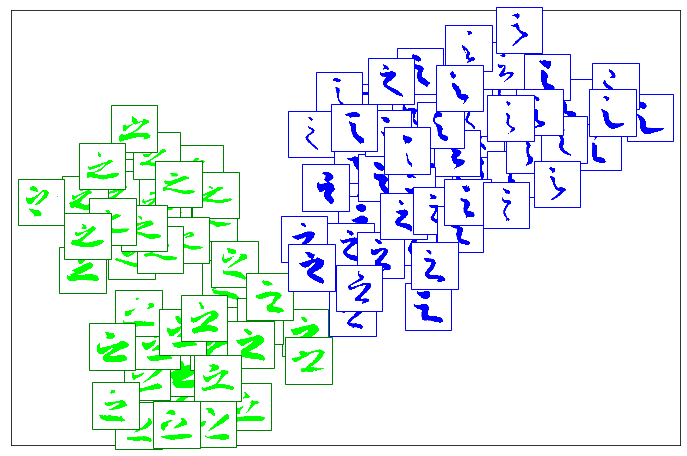

In [14]:
char = '之'
tsne_vis(images[char], img_gists[char], char_labels[char])

## Train-Val-Test Split

In [15]:
def plot_variant_freq(var_counts, include_k1=False, jitter_lvl=0):
    
    freq_cols = ['Variant 1 freq', 'Variant 2 freq', 'Variant 3 freq']
    # count for each char variant


    # tidy data into df
    df = pd.DataFrame(var_counts.values(), columns=freq_cols)
    
    # add noise to frequency
    for col in freq_cols:
        df[col] = df[col].apply(lambda x: x + random.random() * jitter_lvl - jitter_lvl / 2)
    
    df['# clusters'] = [len(x) for x in var_counts.values()]
    
    if not include_k1:
        df = df[df['# clusters'] > 1]
    df.insert(0, 'Total', df[freq_cols].sum(axis=1))
        
    # plot parallel coordinates
    ax = pd.plotting.parallel_coordinates(
        df, 
        '# clusters', 
        color=('#556270', '#4ECDC4', '#C7F464')
    )
    ax.legend(title='# clusters')
    return ax

In [16]:
print('Total -', sum([len(x) for x in char_labels.values()]))

Total - 10035


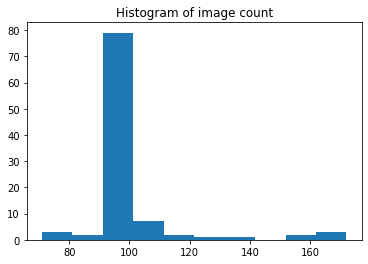

In [17]:
plt.hist([len(x) for x in char_labels.values()])
_ = plt.title('Histogram of image count')

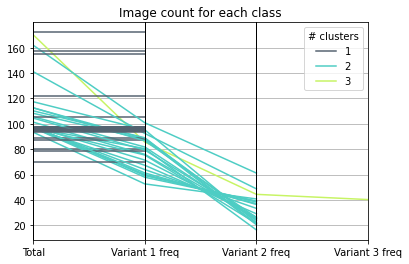

In [18]:
var_counts = {
    char: np.bincount(char_labels[char].astype(int)).tolist() for char in char_labels
}

plot_variant_freq(var_counts, True, 3)
_ = plt.title('Image count for each class')

### Target dataset size

New training samples will be generated through augmentation.

Splitting ratio - roughly 6:2:2
* 20 images per class for each test and validation set
* 160 images per class for training set after upsampling

In [19]:
test_nps = 20
train_aug_nps = 160

In [20]:
test_freq = {}
train_freq = {}
train_freq_aug = {}

for char in char_labels:
    
    var_freqs = np.bincount(char_labels[char].astype(int)).tolist()
    n_cluster = (char_labels[char].max() + 1).astype(int)
    
    test_freq[char] = [int(max(1, min(test_nps / n_cluster, n / 4))) for n in var_freqs]
    test_freq[char][0] += test_nps - sum(test_freq[char])
    
    train_freq[char] = [var_freqs[i] - test_freq[char][i] for i in range(n_cluster)]
    
    tmp = train_aug_nps / n_cluster
    train_freq_aug[char] = [int(max(train_freq[char][i], tmp * (1 - 0.1 * i))) for i in range(n_cluster)]

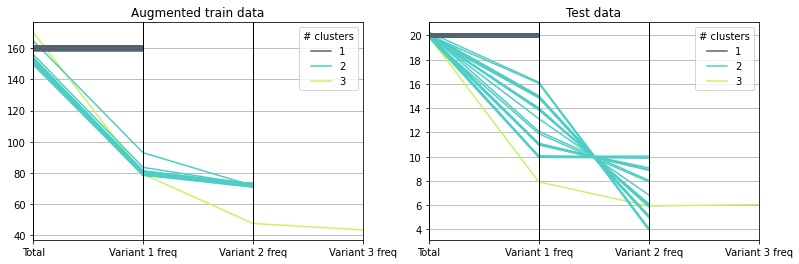

In [21]:
plt.figure(figsize=(13, 4))

ax = plt.subplot(1, 2, 1)
_ = plt.title('Augmented train data')
plot_variant_freq(train_freq_aug, True, 3)

ax = plt.subplot(1, 2, 2)
plot_variant_freq(test_freq, True, 0.3)
_ = plt.title('Test data')

In [22]:
get_total_freq = lambda freqs: sum([sum(x) for x in freqs.values()])

print(
    """
        Target dataset size
        ==========================
        Test              - {}
        Train (initial)   - {}
        Train (augmented) - {}
    """.format(
        get_total_freq(test_freq),
        get_total_freq(train_freq),
        get_total_freq(train_freq_aug),
    )
)


        Target dataset size
        Test              - 2000
        Train (initial)   - 8035
        Train (augmented) - 15856
    


### Generate dataset

In [23]:
def generate_augmented(source_imgs, n):
    if n <= 0:
        return []
    source_imgs = source_imgs.copy()
    random.shuffle(source_imgs)
    idxs = [i % len(source_imgs) for i in range(n)]
    return [augment_image(source_imgs[i]) for i in idxs]


def split_data(data, n):
    data = data.copy()
    random.shuffle(data)
    return data[:n], data[n:]


def write_data(data, data_dir):
    os.mkdir(data_dir)
    for char in data.keys():
        char_path = os.path.join(data_dir, char)
        os.mkdir(char_path)  
        for i, img in enumerate(data[char]):
            fpath = os.path.join(data_dir, char, '{}.png'.format(i))
            cv2.imwrite(fpath, img)

In [24]:
train_data = {}
val_data = {}
test_data = {}

for char in tqdm(images):
    
    train_data[char] = []
    val_data[char] = []
    test_data[char] = []
    
    for i in range(len(test_freq[char])):
        
        idxs = np.where(char_labels[char] == i)[0]
        variants = [images[char][i] for i in idxs]
        
        vars_val, variants = split_data(variants, test_freq[char][i])
        vars_test, variants = split_data(variants, test_freq[char][i])
        vars_train = variants + generate_augmented(variants, train_freq_aug[char][i] - len(variants))
        

        train_data[char] += vars_train
        val_data[char] += vars_val
        test_data[char] += vars_test
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
write_data(train_data, 'data/cccr/train')
write_data(val_data, 'data/cccr/validation')
write_data(test_data, 'data/cccr/test')